# Training VAE or Simple Decoding Models

This notebook will cover two ways to train models with fixed encodings. In both situations, the decoding will be the same. In the first, however, we will not only train a decoding, but also a CG model. In the second scenario, we will only train the decoding.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import vaemolsim

import matplotlib.pyplot as plt

## Creating training data

First, we will create some training data. For this, we will use TensorFlow Probability to come up with a 2D distribution that we will project down to 1D, then decode back. The distribution will be a bit complicated so it's not too trivial, but don't worry about how this is done with TFP. That can be looked up elsewhere and is not the point here.

In [2]:
data_dist = tfp.distributions.JointDistributionSequentialAutoBatched([
    tfp.distributions.Bernoulli(probs=0.5, dtype=tf.float32), # call this k
    lambda k: tfp.distributions.VonMises(loc=2*k - 1, concentration=3.0), # x
    lambda x: tfp.distributions.VonMises(loc=x, concentration=1.0 / (0.05*(1.0 / (x**2)) + 0.001)), # y
])

In [3]:
data_sample = tf.transpose(tf.stack(data_dist.sample(10000)[-2:], axis=0)).numpy()

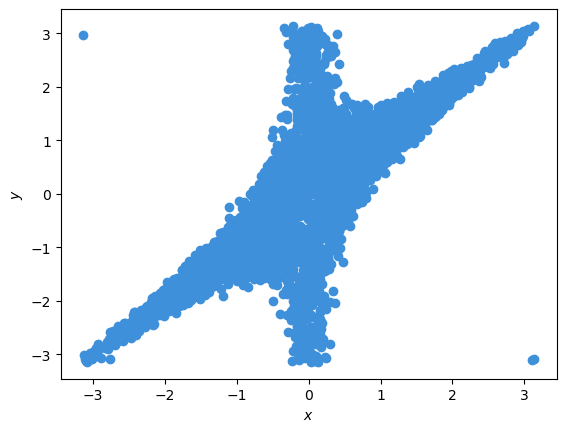

In [4]:
fig, ax = plt.subplots()
ax.scatter(data_sample[:, 0], data_sample[:, 1])
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()

For our CG coordinate, we will simply pick the average of the $x$ and $y$ coordinates. This is likely a pretty descriptive coordinate, but cannot be mapped directly back to $x$ or $y$ exactly.

In [5]:
cg_data = np.average(data_sample, axis=1)[:, None]

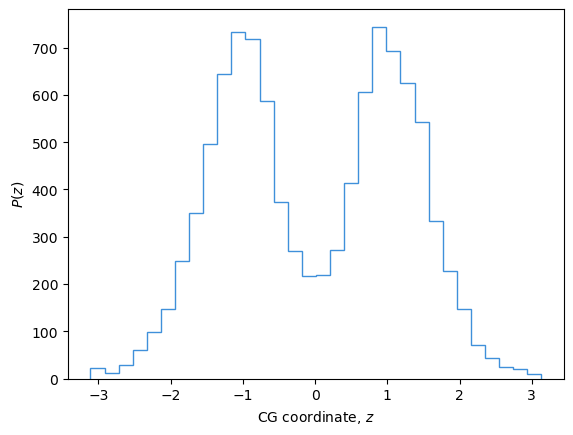

In [6]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(cg_data, bins='auto', histtype='step')
ax.set_xlabel(r'CG coordinate, $z$')
ax.set_ylabel(r'$P(z)$')
plt.show()

## Training a VAE with a deterministic encoding

[Variational autoencoders (VAEs)](https://arxiv.org/abs/1606.05908) are a framework for learning probabilistic models of data that are based on three parts. These three parts are based on representing the model probability of the full-space data $x$ in terms of Bayes Theorem: $P(x) = \frac{P(x|z) P(z)}{P(z|x)}$. 

The first part is an encoding, which takes our full-space data $x$ and defines the conditional probability density of the latent space (or coarse-grained) coordinate $z$ given a specific $x$. In the case of a deterministic coarse-grained mapping, $z = M(x)$, this is a Dirac delta function around the result of the mapping, i.e., $P(z|x) = \delta (z - M(x))$.

The second part is a decoding, which represents the conditional probability of $x$ given a particular $z$. Making the decoding distribution deterministic would not make sense unless there is no dimensionality reduction in moving from $x$ to $z$. If we do change the dimensionality in a way that loses information, there must be degeneracies that arise due to the encoding process, which means that the decoding should be probabilistic. There are [many options](https://doi.org/10.1063/5.0105120) for the decoding distribution, which should be chosen after carefully considering the physics of the system under study.

The third part is the prior distribution $P(z)$. This represents the distribution of the latent space variable, or the coarse-grained model. This can be specified without any learnable parameters, or it can be learned in the process of training. Mainly, we think of this as a static probability density that does not depend on any inputs to the VAE.

In the context of training an autoencoder, we mainly interact with the encoding and decoding parts. We pass a sample of the data we want to learn a probability density for into the encoder, sample a $z$ from the resulting conditional probability distribution, then calculate the probability of the original sample under a decoding distribution predicted from the sampled $z$. Our objective is to maximize the probability of the original sample $x$ under the produced decoding distribution. There is also a regularization term to the loss, which comes into play when we consider the prior distribution. Overall, the regularization term makes sure that the encoding is in fact the inverse of the decoding and prior (that's where the "variational" part comes in), but it also ensures that the coarse-grained distribution, or latent space, is only as complex as it needs to be. This part of the loss term ensures that we learn a coarse-grained model during training and is equivalent to relative entropy coarse graining if the prior is defined in terms of a potential energy.

The prior also plays a much larger role during generation. In this mode, which happens after training, we generate samples of $x$ from the model distribution. We do this by sampling from the learned prior, or coarse-grained distribution $P(z)$, then sampling from the decoding probability distribution $P(x|z)$.

To summarize, a VAE is fully specified by 1) an encoding probability model, 2) a decoding probability model, and 3) a prior probability model. The specific choice of decoding model will dictate the reconstruction loss, while the form of the encoder and prior will dictate the form of the regularization loss. For insights into VAEs in the context of VAE-based MC moves, see the [original paper](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.2c00110), which also discusses the case of a deterministic encoding and the relationship with relative entropy coarse graining.

To start, we will actually need to define an encoding model, in TensorFlow, that performs the deterministic encoding that we want. This just needs to be a mapping operation acting on the input, which here is really simple. The only catch is that this should all be in TensorFlow, which is similar to numpy. Here we will implement this as a custom `tf.keras` Layer class. We only need to implement an `__init__` and a `call` method for this class.

In [7]:
class MapToAverage(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super(MapToAverage, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1, keepdims=True)


We now create an instance of our class, a deterministic distribution, and a layer that applies the mapping to produce this distribution.

In [8]:
cg_mapping = MapToAverage()
encoder_dist = vaemolsim.dists.IndependentDeterministic(event_shape=1) # This is the dimensionality of the CG coordinate
encoder = vaemolsim.models.MappingToDistribution(encoder_dist, mapping=cg_mapping, name='encoder')

In [9]:
encoder(data_sample)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[10000] event_shape=[1] dtype=float32>

Next, we can define a prior. In effect, this will be the learned CG model, since if we learn a probability distribution over the CG coordinate that is the same as learning the normalized PMF. For this, we will just use a flowed distribution starting from a standard normal. Note that rational quadratic spline flows implemented in `vaemolsim` are naturally periodic on the specified interval! To reflect the expected periodicity, we use a standard von Mises distribution as the latent distribution.

In [10]:
prior_flow = vaemolsim.flows.RQSSplineMAF(
    num_blocks=4, # Number of transformation blocks
    # The below dictionary of parameters defines aspects of the neural rational quadratic splines
    rqs_params={'bin_range': [-np.pi, np.pi], # List of min and max values for transformation - data outside this range will NOT be transformed!
                'num_bins': 32, # Number of bins - more is a more powerful transformation but is more expensive
                'hidden_dim': 64, # Number of hidden dimensions in neural networks (should be more than num_bins, ideally)
               }, 
)
_ = prior_flow(cg_data[:2, :]) # Pass any data of right shape through flow to build it right
prior_latent = tfp.layers.DistributionLambda(make_distribution_fn=lambda t: tfp.distributions.Independent(tfp.distributions.VonMises(loc=tf.zeros((tf.shape(t)[0], 1)),
                                                                                                                                     concentration=tf.ones((tf.shape(t)[0], 1))),
                                                                                                                reinterpreted_batch_ndims=1)
                                                   )
prior_dist = vaemolsim.dists.FlowedDistribution(prior_flow, prior_latent, name='prior')

In [11]:
prior_dist(cg_data)

<tfp.distributions._TransformedDistribution 'chain_of_block_3_of_block_2_of_block_1_of_block_0tensor_coercible' batch_shape=[10000] event_shape=[1] dtype=float32>

Finally, we can build a decoding model. We will choose autoregressive von Mises distributions since we will assume we know that the degrees of freedom are periodic. We stack that with a mapping (via a neural network).

In [12]:
decoder_dist = vaemolsim.dists.AutoregressiveBlockwise(
    2, # Number of degrees of freedom
    [tfp.distributions.VonMises,]*2, # CLASS for each probability distribution on each degree of freedom
    conditional=True, # Will take conditional inputs, specifically the CG coordinate
    conditional_event_shape=(1,), # Dimensionality of the CG coordinate
    auto_net_params={'hidden_units': [10, 100, 10]}, # Adjust depth of autoregressive network
)
decoder = vaemolsim.models.MappingToDistribution(decoder_dist, name='decoder')

In [13]:
decoder(cg_data)

<tfp.distributions.Autoregressive 'Autoregressive' batch_shape=? event_shape=? dtype=float32>

Put it all together in a VAE model!  Note that, because we are using a deterministic encoding, we need to specify a loss other than the default.

In [14]:
vae = vaemolsim.models.VAE(encoder, decoder, prior_dist, regularizer=vaemolsim.losses.LogProbRegularizer())

In [15]:
vae(data_sample[:10, :])

<tfp.distributions.Autoregressive 'Autoregressive' batch_shape=? event_shape=? dtype=float32>

In [16]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (MappingToDistribu  multiple                  0         
 tion)                                                           
                                                                 
 decoder (MappingToDistribu  multiple                  3938      
 tion)                                                           
                                                                 
 prior (FlowedDistribution)  multiple                  26236     
                                                                 
Total params: 30174 (117.87 KB)
Trainable params: 30174 (117.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile and train! Note that during fit, the inputs and targets are the same things.

In [17]:
vae.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=vaemolsim.losses.LogProbLoss())

In [18]:
vae.fit(data_sample, data_sample, epochs=10)

Epoch 1/10
313/313 [==============================] - 10s 3ms/step - loss: 2.7440 - kl_div: 1.5615 - regularizer_loss: 1.5615
Epoch 2/10
313/313 [==============================] - 1s 4ms/step - loss: 1.5384 - kl_div: 1.4891 - regularizer_loss: 1.4891
Epoch 3/10
313/313 [==============================] - 1s 4ms/step - loss: 1.4152 - kl_div: 1.4859 - regularizer_loss: 1.4859
Epoch 4/10
313/313 [==============================] - 1s 4ms/step - loss: 1.3450 - kl_div: 1.4825 - regularizer_loss: 1.4825
Epoch 5/10
313/313 [==============================] - 1s 4ms/step - loss: 1.2436 - kl_div: 1.4814 - regularizer_loss: 1.4814
Epoch 6/10
313/313 [==============================] - 1s 4ms/step - loss: 1.1853 - kl_div: 1.4800 - regularizer_loss: 1.4800
Epoch 7/10
313/313 [==============================] - 1s 4ms/step - loss: 1.1369 - kl_div: 1.4800 - regularizer_loss: 1.4800
Epoch 8/10
313/313 [==============================] - 1s 4ms/step - loss: 1.1090 - kl_div: 1.4794 - regularizer_loss: 1.4794

First, we will check if we have learned an appropriate CG model.

In [20]:
model_cg_sample = vae.prior(np.ones((10000, 1))).sample()

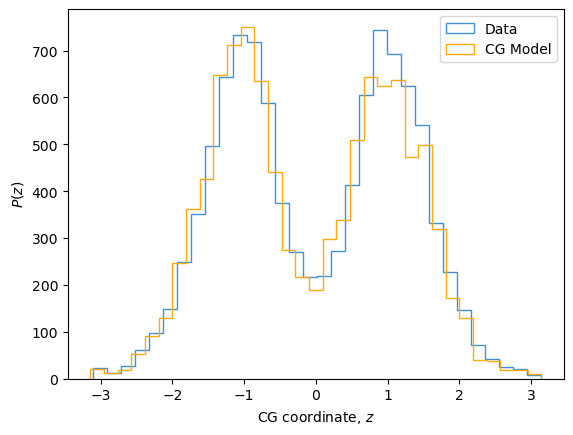

In [21]:
fig, ax = plt.subplots()
_ = ax.hist(cg_data, bins='auto', histtype='step', label='Data')
_ = ax.hist(np.squeeze(model_cg_sample), bins='auto', histtype='step', label='CG Model')
ax.set_xlabel(r'CG coordinate, $z$')
ax.set_ylabel(r'$P(z)$')
ax.legend()
plt.show()

Not bad! Now let's check the decoding model in both reconstruction and decoding modes.

In [22]:
recon_sample = vae(data_sample).sample()
gen_sample = vae.decoder(model_cg_sample).sample()

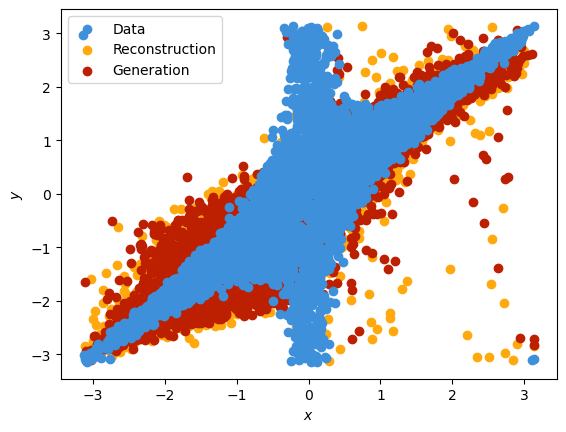

In [23]:
fig, ax = plt.subplots()
ax.scatter(data_sample[:, 0], data_sample[:, 1], label='Data', zorder=10)
ax.scatter(recon_sample[:, 0], recon_sample[:, 1], label='Reconstruction')
ax.scatter(gen_sample[:, 0], gen_sample[:, 1], label='Generation')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()
plt.show()

Not terrible, but it's clear that it's not capturing the right behavior of the $y$-variance as a function of $x$. The good news is that the reconstruction and generation data match nicely. In theory, the autoregressive model with von Mises distributions is sophisticated enough to capture the narrowing behavior. Indeed, it already looks like the variance in $y$ does change with $x$. However, it may take a fair amount more training (or a good random number seed) for the model to learn that the variance (in $y$) goes as $1/x^2$.

## Training only a decoding model

This will be much simpler. In this case, we do not also want to train a CG model and assume that is already known. So now all we want to do is train the decoder. We can easily do that by only creating a `MappingToDistribution` class instance and training that directly. This is a nice feature of TensorFlow - models can be nested together.

In [24]:
only_decoder_dist = vaemolsim.dists.AutoregressiveBlockwise(
    2, # Number of degrees of freedom
    [tfp.distributions.VonMises,]*2, # CLASS for each probability distribution on each degree of freedom
    conditional=True, # Will take conditional inputs, specifically the CG coordinate
    conditional_event_shape=(1,), # Dimensionality of the CG coordinate
    auto_net_params={'hidden_units': [10, 100, 10]}, # Adjust depth of autoregressive network
)
only_decoder = vaemolsim.models.MappingToDistribution(only_decoder_dist)

In [25]:
only_decoder.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=vaemolsim.losses.LogProbLoss())

When fitting, now note that the input is the CG data, while the output is the fine-grained data.

In [26]:
only_decoder.fit(cg_data, data_sample, epochs=10)

Epoch 1/10
313/313 [==============================] - 1s 489us/step - loss: 1.1388
Epoch 2/10
313/313 [==============================] - 0s 481us/step - loss: -0.0202
Epoch 3/10
313/313 [==============================] - 0s 482us/step - loss: -0.1580
Epoch 4/10
313/313 [==============================] - 0s 473us/step - loss: -0.2700
Epoch 5/10
313/313 [==============================] - 0s 471us/step - loss: -0.3236
Epoch 6/10
313/313 [==============================] - 0s 555us/step - loss: -0.3526
Epoch 7/10
313/313 [==============================] - 0s 478us/step - loss: -0.3772
Epoch 8/10
313/313 [==============================] - 0s 472us/step - loss: -0.3921
Epoch 9/10
313/313 [==============================] - 0s 474us/step - loss: -0.4162
Epoch 10/10
313/313 [==============================] - 0s 473us/step - loss: -0.4326


In [27]:
only_decoder.summary()

Model: "map_to_dist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoregressive_blockwise (  multiple                  2332      
 AutoregressiveBlockwise)                                        
                                                                 
 mapping (FCDeepNN)          multiple                  1606      
                                                                 
Total params: 3938 (15.38 KB)
Trainable params: 3938 (15.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
only_decode_sample = only_decoder(cg_data).sample()

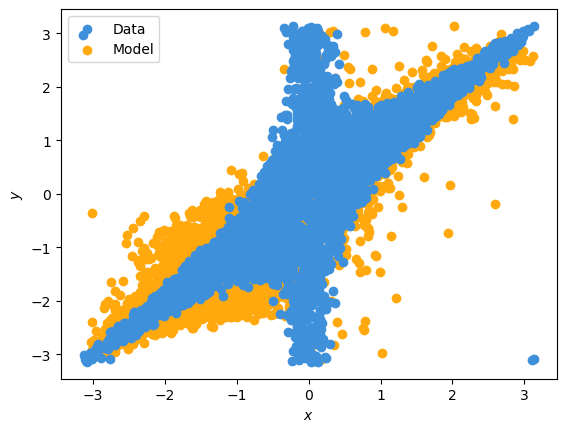

In [29]:
fig, ax = plt.subplots()
ax.scatter(data_sample[:, 0], data_sample[:, 1], label='Data', zorder=10)
ax.scatter(only_decode_sample[:, 0], only_decode_sample[:, 1], label='Model')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()
plt.show()

We get the same result as when we train the CG model at the same time (within the symmetry in the system - it can either pick low $x$ or high $x$ to fit slightly better, apparently). This is because, for a deterministic decoder, training the CG model, or prior, and the decoder are decoupled from each other. The parameters do not depend on each other, so, even though both are trained at the same time in the VAE model, the training is effectively independent.